# InSituPy demonstration - Performance tests

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
from datetime import datetime
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load Xenium data into `InSituData` object

In [3]:
insitupy_project = Path("../demo_dataset/demo_insitupy_project")

In [4]:
xd = read_xenium(insitupy_project)

In [5]:
xd.load_all()

Loading annotations...
Loading cells...
	No alternative cells found...
Loading images...
Loading regions...
Loading transcripts...


In [6]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


## Test writing data to disk

In [7]:
pixel_size = xd.images.metadata["nuclei"]["pixel_size"]
shape_um = tuple([elem * pixel_size for elem in xd.images.nuclei[0].shape])
center = tuple([int(elem / 2) for elem in shape_um])

In [8]:
# parameters
square_width_list = [4000, 2000, 1000, 500, 250]
n_replicates = 3
out_dir = Path("./out")

dt_list_save = []
for _ in range(n_replicates):
    # delete existing output directories
    if out_dir.exists():
        print("Delete existing output directory...")
        shutil.rmtree(out_dir)

    # append empty list to collect results
    dt_list_save.append([])
    for square_width in square_width_list:
        t0 = datetime.now()
        xlim = (int(center[1] - square_width / 2), int(center[1] + square_width / 2))
        ylim = (int(center[0] - square_width / 2), int(center[0] + square_width / 2))

        # crop data
        xd_cropped = xd.crop(xlim=xlim, ylim=ylim)

        # save data
        xd_cropped.saveas(out_dir / f"crop{square_width}")
        t1 = datetime.now()
        dt_list_save[-1].append(t1 - t0)

Saving data to out\crop4000
Saved.
Saving data to out\crop2000
Saved.
Saving data to out\crop1000
Saved.
Saving data to out\crop500
Saved.
Saving data to out\crop250
Saved.
Delete existing output directory...
Saving data to out\crop4000
Saved.
Saving data to out\crop2000
Saved.
Saving data to out\crop1000
Saved.
Saving data to out\crop500
Saved.
Saving data to out\crop250
Saved.
Delete existing output directory...
Saving data to out\crop4000
Saved.
Saving data to out\crop2000
Saved.
Saving data to out\crop1000
Saved.
Saving data to out\crop500
Saved.
Saving data to out\crop250
Saved.


In [9]:
dt_list_save_sec = [[elem.total_seconds() for elem in l] for l in dt_list_save]

In [10]:
df_save = pd.DataFrame(dt_list_save_sec, columns=square_width_list).T
df_save = df_save.reset_index(names="Square width [µm]").melt(id_vars="Square width [µm]", var_name="Replicates", value_name="Time [s]")

In [11]:
df_save

,Square width [µm],Replicates,Time [s]
0,4000,0,17.878841
1,2000,0,6.838400
2,1000,0,3.249555
3,500,0,2.530733
4,250,0,3.594676
5,4000,1,18.138257
6,2000,1,6.276418
7,1000,1,3.453453
8,500,1,2.516817
9,250,1,2.306492


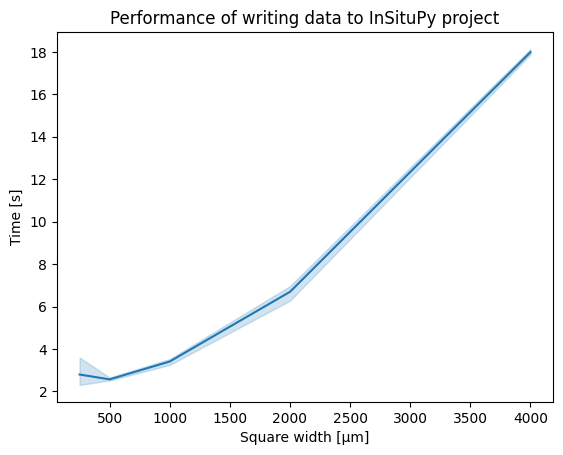

In [13]:
sns.lineplot(df_save, x="Square width [µm]", y="Time [s]")
plt.title("Performance of writing data to InSituPy project")
plt.savefig("performance_writing.pdf")
plt.show()

## Loading performance

In [45]:
t_list = [datetime.now()]
xd = read_xenium(insitupy_project)
t_list.append(datetime.now())
xd.load_images()
t_list.append(datetime.now())
xd.load_cells()
t_list.append(datetime.now())
xd.load_transcripts()
t_list.append(datetime.now())
t_list

Loading images...
Loading cells...
	No alternative cells found...
Loading transcripts...


[datetime.datetime(2024, 8, 8, 8, 40, 26, 864517),
 datetime.datetime(2024, 8, 8, 8, 40, 27, 73415),
 datetime.datetime(2024, 8, 8, 8, 40, 30, 867273),
 datetime.datetime(2024, 8, 8, 8, 40, 31, 231826),
 datetime.datetime(2024, 8, 8, 8, 40, 35, 121990)]

In [52]:
dt_names = ["Metadata", "Images", "Cells", "Transcripts"]
dt_list_load = [t_list[i+1] - t_list[i] for i in range(len(t_list)-1)]

In [53]:
dt_list_load

[datetime.timedelta(microseconds=208898),
 datetime.timedelta(seconds=3, microseconds=793858),
 datetime.timedelta(microseconds=364553),
 datetime.timedelta(seconds=3, microseconds=890164)]

In [10]:
from time import time

In [12]:
import time

In [25]:
t1 = datetime.now()
t2 = datetime.now()
dt = t1 - t2
print(dt)

0:00:00


In [32]:
dt.total_seconds()

0.0

In [ ]:
t1 = time.time()
t2 = time.time()
dt = t1 - t2
time.strftime("%M%S")

'2718'

In [23]:
dt

0.0

In [22]:
time.strftime("%S", dt)

TypeError: Tuple or struct_time argument required

In [21]:
print(dt)

0.0


In [8]:
xd.load_images()
xd.load_cells()

Loading images...
Loading cells...
	No alternative cells found...


Note: That the `annotations` and `regions` modalities are not found here is expected. Annotations and regions are added in a later step.

In [20]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear

## Load annotations

For the analysis of spatial transcriptomic datasets the inclusion of annotations from experts of disease pathology is key. Here, we demonstrate how to annotate data in [QuPath](https://qupath.github.io/), export the annotations as `.geojson` file and import them into the `XeniumData` object.

### Create annotations in QuPath

To create annotations in QuPath, follow these steps:

1. Select a annotation tool from the bar on the top left:

<center><img src="./demo_annotations/qupath_annotation_buttons.jpg" width="300"/></center>

2. Add as many annotations as you want and label them by setting classes in the annotation list. Do not forget to press the "Set class" button:

<center><img src="./demo_annotations/qupath_annotation_list.jpg" width="350"/></center>

3. Export annotations using `File > Export objects as GeoJSON`. Tick `Pretty JSON` to get an easily readable JSON file. The file name needs to have following structure: `annotation-{slide_id}__{sample_id}__{annotation_label}`.

### Import annotations into `XeniumData`

For demonstration purposes, we created a dummy annotation file in `./demo_annotations/`. To add the annotations to `XeniumData` follow the steps below.



In [21]:
xd.import_annotations(
    files=[
        "./demo_annotations/annotations-0001879__Replicate 1__demo.geojson",
        "./demo_annotations/annotations-0001879__Replicate 1__demo2.geojson"
           ],
    keys=["demo", "demo2"]
    )

Importing annotations...


C:\Users\ge37voy\Github\InSituPy\insitupy\_core\dataclasses.py:66: UserWarning: Some annotations were a shapely 'MultiPolygon' objects and skipped.
  self.add_shapes(data=file,


## Load regions

Regions can be created in QuPath either as described above or using tools like the TMA dearrayer. They are also exported as objects as annotations but different to annotations they do not have a classification and each name of a region has to be unique.

In the following demo regions are read. One of the region files has non-unique names to demonstrate the warning that appears in this case.

In [22]:
xd.import_regions(
    files=[
        "./demo_regions/regions-0001879__Replicate 1__demo_regions.geojson",
        "./demo_regions/regions-0001879__Replicate 1__TMA.geojson",
        ],
    keys=['demo_regions', 'TMA'])

Importing regions...


Properties of the added `anotations` and `regions` can be inspected in the XeniumData representation:

In [23]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ annotations
       demo:	4 annotations, 2 classes ('Positive','Negative') 
       demo2:	4 annotations, 3 classes ('Negative','Positive','Other') 
    ➤ regions
       demo_regions:	3 regions, 3 classes ('Region1','Region2','Reg

Both annotations and regions are saved as [`GeoPandas`](https://geopandas.org/en/stable/) dataframes. The main difference between both is that `regions` need to have a unique name while `annotations` are allowed to have duplicate names. In both cases a unique `id` is used for identification.

In [43]:
xd.annotations.demo2

,objectType,geometry,name,color,origin
id,,,,,
1970eccb-ad38-4b4b-b7a8-54509027b57d,annotation,"POLYGON ((5380.28750 827.05000, 5379.01250 827...",Negative,"[112, 112, 225]",file
a3b32cce-1bb9-4a6f-b1d1-9e0c44420cfa,annotation,"POLYGON ((6576.87500 2306.68750, 6575.60000 23...",Positive,"[250, 62, 62]",file
a6c17a54-6839-40b2-8531-c9227635f344,annotation,"POLYGON ((1381.46250 3639.27500, 1380.18750 36...",Other,"[255, 200, 0]",file
e78efe2f-d185-4ab6-9cc9-6621897f3662,annotation,"POLYGON ((6272.92137 3936.13750, 6263.65000 39...",Negative,"[112, 112, 225]",file


In [44]:
xd.regions.TMA

,objectType,name,isMissing,geometry,origin
id,,,,,
7ab5d5a6-49bd-4122-bc64-05477bc0207b,tmaCore,B-2,False,"POLYGON ((4299.61025 4213.18862, 4298.62425 42...",file
06ef93c1-f86d-45e6-ad9a-896e254638ea,tmaCore,A-3,False,"POLYGON ((7201.19150 903.26738, 7200.20550 934...",file
7933d3fd-ccd3-46af-8f15-fcc01ec9c128,tmaCore,B-1,False,"POLYGON ((1555.14725 4333.64638, 1554.15912 43...",file
7015118d-2947-48e3-baf0-4b220a76a951,tmaCore,B-3,False,"POLYGON ((7311.17300 4228.90087, 7310.18700 42...",file
bf86657f-31f6-40fe-983b-f80c3d75512b,tmaCore,A-1,False,"POLYGON ((1481.82625 908.50338, 1480.83812 939...",file
440d8f00-fb0e-42e7-9f98-30d30adfc8df,tmaCore,A-2,False,"POLYGON ((4173.91650 856.13063, 4172.93050 887...",file


### Visualize and edit annotations and regions using napari

To visualize annotations and regions in napari, three widgets are available:
- "Add annotations"
- "Show regions"
- "Show annotations"

The widgets "Show annotations" and "Show regions" are grouped together and accessible via tabs:

<left><img src="./demo_annotations/napari_region+annotations_widget.jpg" width="300"/></left>


Using thes widgets, annotations and regions can be displayed. New annotations can be added using the "Add annotations" widget.

Annotations can also be displayed while starting the napari viewer with `.show()` using the `annotation_keys` argument:


In [47]:
xd.show(annotation_keys="all")

#### Annotation layers

The annotations are added as shapes layers to the layer list. The layer name always starts with a "*" and has following syntax: `"* Class (Label)"`:

<left><img src="./demo_annotations/napari_layerlist_annotations.jpg" width="300"/></left>

- **Label**: A label for one collection of annotations. Could e.g. tell us who did the annotations or what is the focus of this collection of annotations.
- **Class**: Specifies the class of one specific annotation. Could be e.g. the name of cells, the morphological structure or the disease state annotated.

#### Add custom annotations using the Annotation Widget

<left><img src="./demo_annotations/napari_annotation_widget.jpg" width="200"/></left>

By clicking the `"Add annotation layer"` button a new layer with the above mentioned syntax is added. The layer controls on the top left can be then used to add new shapes as annotations:

<left><img src="./demo_annotations/napari_layerconrols_annotations.jpg" width="300"/></left>

An example annotation is shown here:

<left><img src="./demo_annotations/napari_annotation_example.jpg" width="200"/></left>

The annotations can then be stored in the `XeniumData` object using the `store_annotations` function.


In [15]:
xd.store_annotations()

Added 3 new annotations to existing key 'demo2'


In [16]:
xd

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ annotations
       demo:	4 annotations, 2 classes ('Positive','Negative') 
       demo2:	7 annotations, 4 classes ('Negative','Positive','Other','test_class') 
    ➤ regions
       demo_regions:	3 regions, 3 classes ('Region1','Region2','Region3') 
       TMA:	6 regions, 6 classes (

### Assign annotations to observations

To use the annotations in analyses (e.g. to select only observations within a certain annotation or compare gene expression between different annotations) one can use the `assign_annotations` function. It adds columns containing the annotation class to `xd.matrix.obs`. The column has the syntax `annotation-{Label}` and if an observation is not part of any annotation within this label, it contains `NaN`. 

In [17]:
xd.assign_annotations()

Assigning key 'demo'...
Assigning key 'demo2'...


After assigning the annotations, the labels analyzed here are marked with a ✔:

In [18]:
xd

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ annotations
       demo:	4 annotations, 2 classes ('Positive','Negative') ✔
       demo2:	7 annotations, 4 classes ('Negative','Positive','Other','test_class') ✔
    ➤ regions
       demo_regions:	3 regions, 3 classes ('Region1','Region2','Regi

Following cells show examples how to explore the assigned annotations:

In [19]:
# print number of cells within one annotation
xd.cells.matrix.obs["annotation-demo2"].notna().sum()

21199

In [20]:
# show only observations that were part of this annotation label
xd.cells.matrix.obs[xd.cells.matrix.obs["annotation-demo2"].notna()]

,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,annotation-demo,annotation-demo2
4921,281,0,0,281,733.247187,26.010000,NaN,Other
4922,273,1,0,274,380.576875,30.074063,NaN,Other
4923,189,2,0,191,285.658437,8.263594,NaN,Other
4924,212,0,0,212,282.226562,24.068281,NaN,Other
4925,58,0,0,58,81.823125,4.470469,NaN,Other
...,...,...,...,...,...,...,...,...
165374,96,1,0,97,150.234844,11.063281,Negative,Negative
165375,379,0,0,379,153.666719,75.681875,Negative,Negative
165376,101,0,0,101,27.996875,17.836719,Negative,Negative
165377,472,0,0,472,200.177656,52.652188,Negative,Negative


## Save imported annotations in `InSituPy` project

In [25]:
xd.save()

Updating project in c:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
	Updating cells...
	Updating annotations...
	Updating regions...
Saved.
Reloading following modalities: annotations,cells,images,regions
Loading annotations...
Loading cells...
	No alternative cells found...
Loading images...
Loading regions...


In [26]:
xd.show()